In [1]:
from closure_funcs import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib.colors as mcolors
from scipy.stats import linregress

In [2]:
merged = pd.read_csv('../tables/merged_observed.csv')

In [3]:
merged = merged[np.logical_not((merged['Ice_Flag_2DS']==1) | (merged['ED-liquid_2DS']>=60E-6) | (merged['LWC_FCDP']>0.005) | (merged['ams_tot'] < 0.04) | (merged['N_CCN_stdPT'] < 50))].reset_index(drop=True)

In [4]:
def calc_vf(data, org_k = 0.14, so4_k = 0.507):
    d = data.copy()

    d['Org_vc'] = d['Org_Ave_IsoK_STP'] / 1000
    d['SO4_vc'] = d['SO4_Ave_IsoK_STP'] / 1770
    d['NO3_vc'] = d['NO3_Ave_IsoK_STP'] / 1770
    d['NH4_vc'] = d['NH4_Ave_IsoK_STP'] / 1770
    d['Chl_vc'] = d['Chl_Ave_IsoK_STP'] / 2200

    d['ams_tot_vc'] = d['Org_vc']+d['SO4_vc']+d['NO3_vc']+d['NH4_vc']+d['Chl_vc']

    d['k'] = org_k*d['Org_vc']/d['ams_tot_vc'] + so4_k*d['SO4_vc']/d['ams_tot_vc'] + 0.507*d['NO3_vc']/d['ams_tot_vc'] + 0.507*d['NH4_vc']/d['ams_tot_vc'] + 0.507*d['Chl_vc']/d['ams_tot_vc']#0.035543

    return d

In [5]:
merged = calc_vf(merged)#, org_k = .14, so4_k = .14)

In [6]:
# merged['k'].plot.hist(bins=80000)
# plt.xlim([-1,1])
# plt.xlabel('$\kappa$')
# plt.savefig('./figures/k_hist.png', dpi=300)

In [7]:
sub_m = merged[(merged['k'] > 0) & (merged['k'] <= 1) & (np.isfinite(merged['CCN_SS']))]

In [8]:
sub_m_og = sub_m.copy()

In [9]:
sub_m

,Unnamed: 0,index,Time_Mid,SMPS_Bin02,SMPS_Bin03,SMPS_Bin04,SMPS_Bin05,SMPS_Bin06,SMPS_Bin07,SMPS_Bin08,...,k_obs,D_c,CCN_n_pred,Org_vc,SO4_vc,NO3_vc,NH4_vc,Chl_vc,ams_tot_vc,k
0,0,0,2020-02-14 17:02:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.058606,165.719578,474.899915,0.000902,0.000670,0.000399,0.000460,0.000005,0.002436,0.035543
1,1,1,2020-02-14 17:03:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005341,164.448811,460.601458,0.001183,0.000804,0.000163,0.000440,0.000005,0.002595,0.035543
2,2,2,2020-02-14 17:04:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.047530,153.136738,404.600211,0.000779,0.000894,0.000179,0.000430,-0.000005,0.002276,0.035543
3,3,3,2020-02-14 17:05:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005356,154.249870,335.299981,0.000223,0.000555,0.000095,0.000323,-0.000010,0.001185,0.035543
4,4,4,2020-02-14 17:06:30.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.026723,161.392784,320.799468,0.000494,0.000667,0.000161,0.000362,0.000019,0.001702,0.035543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16678,25344,25344,2022-06-18 15:11:01.500,0.0,0.0,0.0,0.00,0.0,640.37,0.00,...,0.100171,99.568518,3840.998151,0.006852,0.000592,0.000190,0.000289,-0.000009,0.007915,0.035543
16679,25345,25345,2022-06-18 15:12:01.500,0.0,0.0,0.0,3172.65,0.0,635.06,0.00,...,0.168431,83.934736,4034.499619,0.006443,0.000525,0.000208,0.000285,0.000013,0.007474,0.035543
16680,25346,25346,2022-06-18 15:13:01.500,0.0,0.0,0.0,0.00,0.0,0.00,434.85,...,0.060140,117.571932,2417.998515,0.006588,0.000573,0.000223,0.000323,0.000028,0.007735,0.035543
16681,25347,25347,2022-06-18 15:14:01.500,0.0,0.0,0.0,0.00,0.0,591.20,0.00,...,0.069678,112.088811,2454.998363,0.007012,0.000602,0.000227,0.000303,0.000010,0.008154,0.035543


In [10]:
sub_m = sub_m.copy().reset_index()
sub_m['D_c'] = np.nan
for i in tqdm(range(0,len(sub_m))):
    row = sub_m.iloc[i]
    #sub_m.loc[i, 'D_c'] = Dc_calculator(row['k'], row['CCN_SS'])
    #sub_m.loc[i, 'D_c'] = calculate_critical_diameter(row['CCN_SS'], row['k'])
    sub_m.loc[i, 'D_c'] = find_d_act(row['CCN_SS'], row['k'])

100%|██████████| 13983/13983 [00:04<00:00, 3094.38it/s]


In [11]:
sub_m = sub_m[np.logical_not(sub_m['D_c'].isna())]

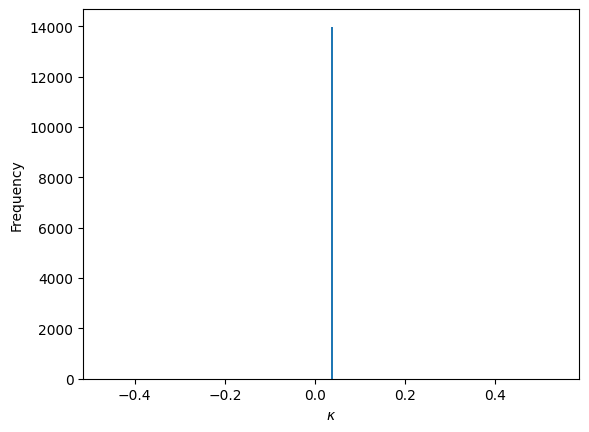

In [33]:
sub_m['k'].plot.hist(bins=250)
#plt.xlim([-1,1])
plt.xlabel(r'$\kappa$')
plt.savefig('../figures/k_hist.png', dpi=300)

In [13]:
sub_m['k'].median()

np.float64(0.035543)

In [14]:
sub_m[np.isfinite(sub_m['k'])]

,level_0,Unnamed: 0,index,Time_Mid,SMPS_Bin02,SMPS_Bin03,SMPS_Bin04,SMPS_Bin05,SMPS_Bin06,SMPS_Bin07,...,k_obs,D_c,CCN_n_pred,Org_vc,SO4_vc,NO3_vc,NH4_vc,Chl_vc,ams_tot_vc,k
0,0,0,0,2020-02-14 17:02:30.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.058606,195.016516,474.899915,0.000902,0.000670,0.000399,0.000460,0.000005,0.002436,0.035543
1,1,1,1,2020-02-14 17:03:30.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005341,96.709165,460.601458,0.001183,0.000804,0.000163,0.000440,0.000005,0.002595,0.035543
2,2,2,2,2020-02-14 17:04:30.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.047530,168.198374,404.600211,0.000779,0.000894,0.000179,0.000430,-0.000005,0.002276,0.035543
3,3,3,3,2020-02-14 17:05:30.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005356,91.287469,335.299981,0.000223,0.000555,0.000095,0.000323,-0.000010,0.001185,0.035543
4,4,4,4,2020-02-14 17:06:30.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.026723,147.437870,320.799468,0.000494,0.000667,0.000161,0.000362,0.000019,0.001702,0.035543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13978,16678,25344,25344,2022-06-18 15:11:01.500,0.0,0.0,0.0,0.00,0.0,640.37,...,0.100171,139.198928,3840.998151,0.006852,0.000592,0.000190,0.000289,-0.000009,0.007915,0.035543
13979,16679,25345,25345,2022-06-18 15:12:01.500,0.0,0.0,0.0,3172.65,0.0,635.06,...,0.168431,139.198928,4034.499619,0.006443,0.000525,0.000208,0.000285,0.000013,0.007474,0.035543
13980,16680,25346,25346,2022-06-18 15:13:01.500,0.0,0.0,0.0,0.00,0.0,0.00,...,0.060140,139.198928,2417.998515,0.006588,0.000573,0.000223,0.000323,0.000028,0.007735,0.035543
13981,16681,25347,25347,2022-06-18 15:14:01.500,0.0,0.0,0.0,0.00,0.0,591.20,...,0.069678,139.198928,2454.998363,0.007012,0.000602,0.000227,0.000303,0.000010,0.008154,0.035543


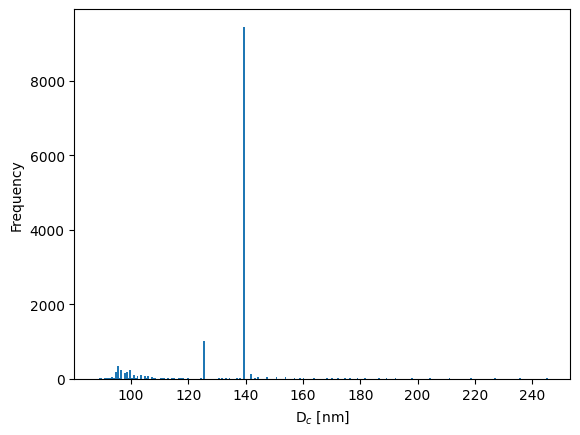

In [15]:
sub_m['D_c'].plot.hist(bins=250)
#plt.xlim([-1,1])
plt.xlabel('D$_c$ [nm]')
plt.savefig('../figures/Dc_hist.png', dpi=300)

In [16]:
sub_m['D_c'].median()

np.float64(139.1989276492098)

In [17]:
sub_m[np.isfinite(sub_m['D_c'])]

,level_0,Unnamed: 0,index,Time_Mid,SMPS_Bin02,SMPS_Bin03,SMPS_Bin04,SMPS_Bin05,SMPS_Bin06,SMPS_Bin07,...,k_obs,D_c,CCN_n_pred,Org_vc,SO4_vc,NO3_vc,NH4_vc,Chl_vc,ams_tot_vc,k
0,0,0,0,2020-02-14 17:02:30.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.058606,195.016516,474.899915,0.000902,0.000670,0.000399,0.000460,0.000005,0.002436,0.035543
1,1,1,1,2020-02-14 17:03:30.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005341,96.709165,460.601458,0.001183,0.000804,0.000163,0.000440,0.000005,0.002595,0.035543
2,2,2,2,2020-02-14 17:04:30.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.047530,168.198374,404.600211,0.000779,0.000894,0.000179,0.000430,-0.000005,0.002276,0.035543
3,3,3,3,2020-02-14 17:05:30.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005356,91.287469,335.299981,0.000223,0.000555,0.000095,0.000323,-0.000010,0.001185,0.035543
4,4,4,4,2020-02-14 17:06:30.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.026723,147.437870,320.799468,0.000494,0.000667,0.000161,0.000362,0.000019,0.001702,0.035543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13978,16678,25344,25344,2022-06-18 15:11:01.500,0.0,0.0,0.0,0.00,0.0,640.37,...,0.100171,139.198928,3840.998151,0.006852,0.000592,0.000190,0.000289,-0.000009,0.007915,0.035543
13979,16679,25345,25345,2022-06-18 15:12:01.500,0.0,0.0,0.0,3172.65,0.0,635.06,...,0.168431,139.198928,4034.499619,0.006443,0.000525,0.000208,0.000285,0.000013,0.007474,0.035543
13980,16680,25346,25346,2022-06-18 15:13:01.500,0.0,0.0,0.0,0.00,0.0,0.00,...,0.060140,139.198928,2417.998515,0.006588,0.000573,0.000223,0.000323,0.000028,0.007735,0.035543
13981,16681,25347,25347,2022-06-18 15:14:01.500,0.0,0.0,0.0,0.00,0.0,591.20,...,0.069678,139.198928,2454.998363,0.007012,0.000602,0.000227,0.000303,0.000010,0.008154,0.035543


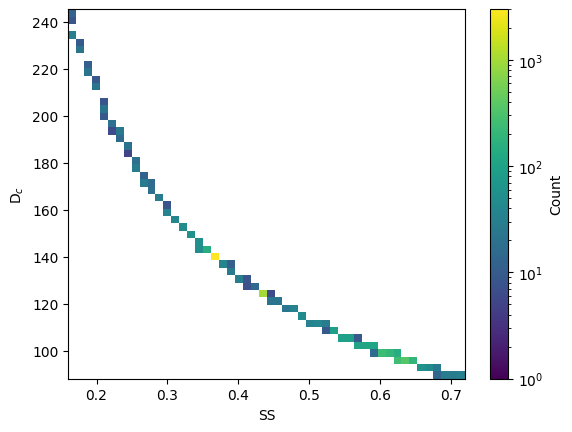

In [18]:
log_norm = mcolors.LogNorm(vmin=1, vmax=3000)

plt.hist2d(sub_m['CCN_SS'], sub_m['D_c'], bins=50, cmap='viridis', norm=log_norm)
plt.colorbar(label='Count', norm=log_norm)
plt.xlabel('SS')
plt.ylabel('D$_c$')
plt.savefig('../figures/D_c-SS.png', dpi=300)

In [19]:
bin_labels = ['SMPS_Bin02', 'SMPS_Bin03', 'SMPS_Bin04', 'SMPS_Bin05',
       'SMPS_Bin06', 'SMPS_Bin07', 'SMPS_Bin08', 'SMPS_Bin09', 'SMPS_Bin10',
       'SMPS_Bin11', 'SMPS_Bin12', 'SMPS_Bin13', 'SMPS_Bin14', 'SMPS_Bin15',
       'SMPS_Bin16', 'SMPS_Bin17', 'SMPS_Bin18', 'SMPS_Bin19', 'SMPS_Bin20',
       'SMPS_Bin21', 'SMPS_Bin22', 'SMPS_Bin23', 'SMPS_Bin24', 'SMPS_Bin25',
       'SMPS_Bin26', 'SMPS_Bin27', 'SMPS_Bin28', 'SMPS_Bin29', 'SMPS_Bin30', 'LAS_Bin01', 'LAS_Bin02', 'LAS_Bin03', 'LAS_Bin04', 'LAS_Bin05',
       'LAS_Bin06', 'LAS_Bin07', 'LAS_Bin08', 'LAS_Bin09', 'LAS_Bin10',
       'LAS_Bin11', 'LAS_Bin12', 'LAS_Bin13', 'LAS_Bin14', 'LAS_Bin15',
       'LAS_Bin16', 'LAS_Bin17', 'LAS_Bin18', 'LAS_Bin19', 'LAS_Bin20',
       'LAS_Bin21', 'LAS_Bin22', 'LAS_Bin23', 'LAS_Bin24', 'LAS_Bin25',
       'LAS_Bin26']

lower_bounds = [3.36, 3.76, 4.22, 4.74, 5.32, 5.97, 6.69, 7.51, 8.43, 9.46, 10.6, 11.9, 13.4, 15.0, 16.8, 18.9, 21.2, 23.8, 26.7, 29.9, 33.6, 37.6, 42.2, 47.4, 53.2, 59.7, 66.9, 75.1, 84.3, 93.9, 106.1, 119.0, 133.6, 149.9, 168.2, 188.7, 211.7, 237.5, 266.5, 299.0, 335.5, 376.5, 422.4, 473.9, 531.8, 596.6, 669.5, 751.1, 842.8, 945.6, 1129.5, 1421.9, 1790.1, 2253.6, 2837.1]
upper_bounds = [3.76, 4.22, 4.74, 5.32, 5.97, 6.69, 7.51, 8.43, 9.46, 10.6, 11.9, 13.4, 15.0, 16.8, 18.9, 21.2, 23.8, 26.7, 29.9, 33.6, 37.6, 42.2, 47.4, 53.2, 59.7, 66.9, 75.1, 84.3, 94.0, 106.1, 119.0, 133.6, 149.9, 168.2, 188.7, 211.7, 237.5, 266.5, 299.0, 335.5, 376.5, 422.4, 473.9, 531.8, 596.6, 669.5, 751.1, 842.8, 945.6, 1129.5, 1421.9, 1790.1, 2253.6, 2837.1, 3487.5]

dlogd=[]
for i in range(0,len(lower_bounds)):
       dlogd.append(np.log(upper_bounds[i]) - np.log(lower_bounds[i]))

In [20]:
dlogd

[np.float64(0.11247798342669024),
 np.float64(0.11541617064611742),
 np.float64(0.11620200765906463),
 np.float64(0.11543616764656806),
 np.float64(0.11527362405095753),
 np.float64(0.11386694673562636),
 np.float64(0.11562159163590646),
 np.float64(0.11556130623772054),
 np.float64(0.11527561105002304),
 np.float64(0.11378161805423437),
 np.float64(0.11568439899946226),
 np.float64(0.11871630683938195),
 np.float64(0.1127954941453444),
 np.float64(0.11332868530700324),
 np.float64(0.11778303565638337),
 np.float64(0.11483925961237018),
 np.float64(0.11568439899946226),
 np.float64(0.11497798472877463),
 np.float64(0.11319491499043677),
 np.float64(0.11666758657251819),
 np.float64(0.11247798342669002),
 np.float64(0.11541617064611742),
 np.float64(0.11620200765906485),
 np.float64(0.11543616764656761),
 np.float64(0.11527362405095776),
 np.float64(0.11386694673562658),
 np.float64(0.11562159163590646),
 np.float64(0.1155613062377201),
 np.float64(0.10891291726219432),
 np.float64(0.12

In [21]:
sub_m2 = sub_m.copy()
sub_m2['CCN_n_pred'] = np.nan
bl_length = len(bin_labels)
#bin_pres_frac = []
for i in tqdm(range(0, len(sub_m2))):
    row = sub_m2.iloc[i]
    d_c = row['D_c']

    for j, ub in enumerate(upper_bounds):
        #print(lb)
        if d_c < ub:
            break
    
    bin_frac = (upper_bounds[j] - d_c) / (upper_bounds[j] - lower_bounds[j])

    count = 0
    if np.isfinite(row[bin_labels[j]]*bin_frac):
        sub_m2.loc[i, 'CCN_n_pred'] = row[bin_labels[j]]*bin_frac*dlogd[j]
        count+=1
    else:
        sub_m2.loc[i, 'CCN_n_pred'] = 0
    for k in range(j+1, bl_length):
        if np.isfinite(row[bin_labels[k]]):
            sub_m2.loc[i, 'CCN_n_pred'] += row[bin_labels[k]]*dlogd[k]
            count += 1
    if count/(bl_length-j) < .9:
        sub_m2.loc[i, 'CCN_n_pred'] = np.nan
    #bin_pres_frac.append(count/(bl_length-j))
sub_m2_og = sub_m2.copy()

100%|██████████| 13983/13983 [00:23<00:00, 585.68it/s]


In [22]:
sub_m2 = sub_m2[np.isfinite(sub_m2['CCN_n_pred'])]
sub_m2 = sub_m2[sub_m2['N_CCN_stdPT']>0]

In [23]:
sub_m2_og.keys()

Index(['level_0', 'Unnamed: 0', 'index', 'Time_Mid', 'SMPS_Bin02',
       'SMPS_Bin03', 'SMPS_Bin04', 'SMPS_Bin05', 'SMPS_Bin06', 'SMPS_Bin07',
       ...
       'k_obs', 'D_c', 'CCN_n_pred', 'Org_vc', 'SO4_vc', 'NO3_vc', 'NH4_vc',
       'Chl_vc', 'ams_tot_vc', 'k'],
      dtype='object', length=104)

In [24]:
#sub_m2_og = sub_m2.copy()
#sub_m2 = sub_m2_og[(sub_m2_og['CCN_n_pred']>10) & (sub_m2_og['N_CCN_stdPT']>30)]

In [25]:
sub_m2[np.logical_not(sub_m2['CCN_n_pred'].isna())]

,level_0,Unnamed: 0,index,Time_Mid,SMPS_Bin02,SMPS_Bin03,SMPS_Bin04,SMPS_Bin05,SMPS_Bin06,SMPS_Bin07,...,k_obs,D_c,CCN_n_pred,Org_vc,SO4_vc,NO3_vc,NH4_vc,Chl_vc,ams_tot_vc,k
0,0,0,0,2020-02-14 17:02:30.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.058606,195.016516,331.709776,0.000902,0.000670,0.000399,0.000460,0.000005,0.002436,0.035543
1,1,1,1,2020-02-14 17:03:30.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005341,96.709165,848.302641,0.001183,0.000804,0.000163,0.000440,0.000005,0.002595,0.035543
2,2,2,2,2020-02-14 17:04:30.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.047530,168.198374,346.969027,0.000779,0.000894,0.000179,0.000430,-0.000005,0.002276,0.035543
3,3,3,3,2020-02-14 17:05:30.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005356,91.287469,603.169201,0.000223,0.000555,0.000095,0.000323,-0.000010,0.001185,0.035543
4,4,4,4,2020-02-14 17:06:30.500,NaN,NaN,NaN,NaN,NaN,NaN,...,0.026723,147.437870,381.949938,0.000494,0.000667,0.000161,0.000362,0.000019,0.001702,0.035543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13978,16678,25344,25344,2022-06-18 15:11:01.500,0.0,0.0,0.0,0.00,0.0,640.37,...,0.100171,139.198928,1765.834264,0.006852,0.000592,0.000190,0.000289,-0.000009,0.007915,0.035543
13979,16679,25345,25345,2022-06-18 15:12:01.500,0.0,0.0,0.0,3172.65,0.0,635.06,...,0.168431,139.198928,1432.249419,0.006443,0.000525,0.000208,0.000285,0.000013,0.007474,0.035543
13980,16680,25346,25346,2022-06-18 15:13:01.500,0.0,0.0,0.0,0.00,0.0,0.00,...,0.060140,139.198928,1613.225111,0.006588,0.000573,0.000223,0.000323,0.000028,0.007735,0.035543
13981,16681,25347,25347,2022-06-18 15:14:01.500,0.0,0.0,0.0,0.00,0.0,591.20,...,0.069678,139.198928,1451.533814,0.007012,0.000602,0.000227,0.000303,0.000010,0.008154,0.035543


In [26]:
sub_m.keys()

Index(['level_0', 'Unnamed: 0', 'index', 'Time_Mid', 'SMPS_Bin02',
       'SMPS_Bin03', 'SMPS_Bin04', 'SMPS_Bin05', 'SMPS_Bin06', 'SMPS_Bin07',
       ...
       'k_obs', 'D_c', 'CCN_n_pred', 'Org_vc', 'SO4_vc', 'NO3_vc', 'NH4_vc',
       'Chl_vc', 'ams_tot_vc', 'k'],
      dtype='object', length=104)

In [27]:
# plt.hist2d(sub_m2['N_CCN_stdPT'], sub_m2['CCN_n_pred'], bins=10000, cmap='bone_r', linewidths=0)
# plt.colorbar(label='count in bin')
# plt.plot(xy, xy, c='r', ls='--')
# plt.xlim([0,2000])
# plt.ylim([0,4000])
# plt.xlabel('N_CCN_stdPT')
# plt.ylabel('CCN_n_pred')
# plt.show()

In [28]:
sub_m2[sub_m2['N_CCN_stdPT']<50]

,level_0,Unnamed: 0,index,Time_Mid,SMPS_Bin02,SMPS_Bin03,SMPS_Bin04,SMPS_Bin05,SMPS_Bin06,SMPS_Bin07,...,k_obs,D_c,CCN_n_pred,Org_vc,SO4_vc,NO3_vc,NH4_vc,Chl_vc,ams_tot_vc,k


Text(0.5, 0, 'Measured CCN [cm$^{-3}$]')

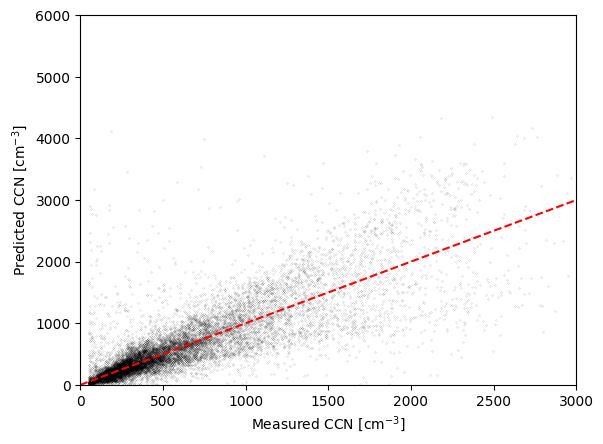

In [29]:
plt.scatter(sub_m2['N_CCN_stdPT'], sub_m2['CCN_n_pred'], s=.005, c='black')
xy = np.linspace(0,10000)
plt.plot(xy, xy, c='r', ls='--')
plt.xlim([0,3000])
plt.ylim([0,6000])
plt.ylabel('Predicted CCN [cm$^{-3}$]')
plt.xlabel('Measured CCN [cm$^{-3}$]')

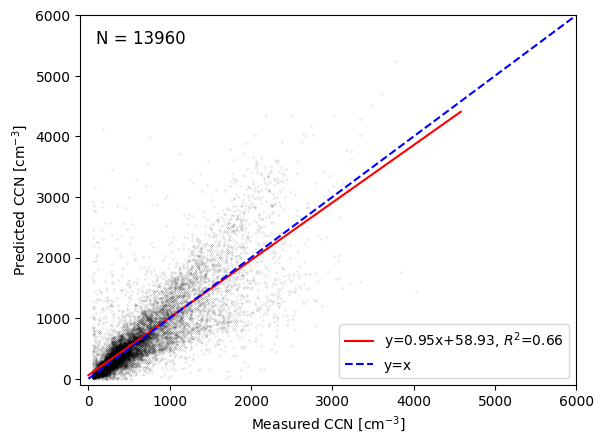

In [30]:
# Define the data
sub_m3 = sub_m2[sub_m2['N_CCN_stdPT']>50]
x = sub_m3['N_CCN_stdPT']
y = sub_m3['CCN_n_pred']
mask = ~np.isnan(x) & ~np.isnan(y)
num_points = np.sum(mask)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the line of best fit
fit_line = slope * np.linspace(0, x.max()) + intercept

# Plot the data and best fit line
plt.scatter(x, y, s=0.005, c='black')
plt.plot(np.linspace(0, x.max()), fit_line, c='r', label=f'y={slope:.2f}x+{intercept:.2f}, $R^2$={r_value**2:.2f}')
plt.plot(np.linspace(0, 6000), np.linspace(0, 6000), c='b', ls='--', label='y=x')
plt.xlim([-100, 6000])
plt.ylim([-100, 6000])
plt.ylabel('Predicted CCN [cm$^{-3}$]')
plt.xlabel('Measured CCN [cm$^{-3}$]')

plt.text(0.15, 0.85, f"N = {num_points}",
         fontsize=12, transform=plt.gcf().transFigure,
         verticalalignment='top', horizontalalignment='left')

plt.legend(loc='lower right')
plt.savefig('../figures/closure1.png', dpi=300)

In [31]:
d_group = sub_m3

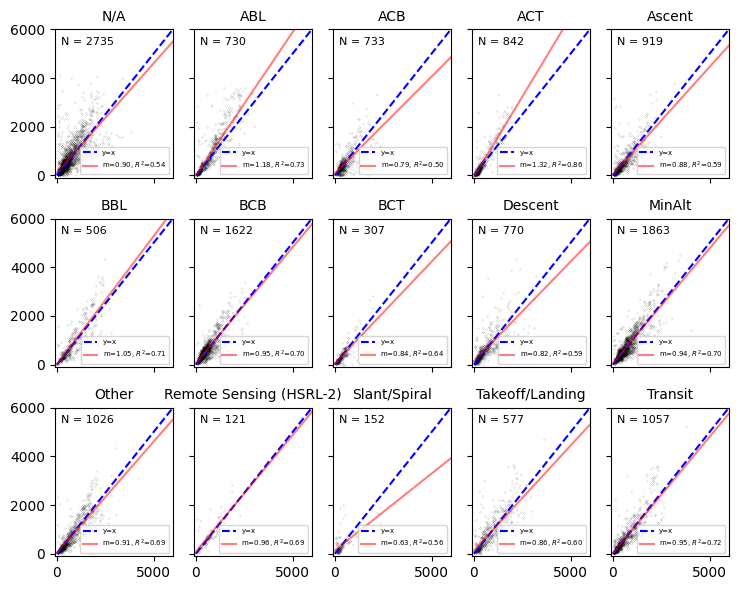

In [32]:
fig, axes = plt.subplots(3,5,figsize=(7.5, 6), sharex='all', sharey='all')
leg_labels = ['0', 'ABL', 'ACB', 'ACT', 'Ascent', 'BBL', 'BCB', 'BCT', 'Descent',
       'MinAlt', 'Other', 'Remote Sensing (HSRL-2)', 'Slant/Spiral',
       'Takeoff/Landing', 'Transit']
for i, ax in enumerate(axes.flatten()):
    if leg_labels[i] == '0':
        d_i = d_group[d_group['leg'].isna()]
    else:
        d_i = d_group[d_group['leg'] == leg_labels[i]]
    ax.scatter(d_i['N_CCN_stdPT'], d_i['CCN_n_pred'], s=0.005, c='black')
    ax.set_title(leg_labels[i], fontsize=10)
    ax.plot(np.linspace(0, 6000), np.linspace(0, 6000), c='b', ls='--', label='y=x')

    slope, intercept, r_value, p_value, std_err = linregress(d_i['N_CCN_stdPT'], d_i['CCN_n_pred'])
    # Calculate the line of best fit
    fit_line = slope * np.linspace(0, 6000) + intercept
    ax.plot(np.linspace(0, 6000), fit_line, c='r', label=f'm={slope:.2f}, $R^2$={r_value**2:.2f}', alpha=.5)
    ax.legend(fontsize=5, loc='lower right')
    mask = ~np.isnan(d_i['N_CCN_stdPT']) & ~np.isnan(d_i['CCN_n_pred'])
    num_points = np.sum(mask)
    ax.text(0.05, 0.95, f"N = {num_points}",
         fontsize=8, transform=ax.transAxes,
         verticalalignment='top', horizontalalignment='left')

axes[0,0].set_title('N/A', fontsize=10)
axes[0,0].set_xlim([-100, 6000])
axes[0,0].set_ylim([-100, 6000])
fig.tight_layout()
plt.savefig('../figures/all_legs_hor.png', dpi=300, bbox_inches='tight')